In [1]:
import os, yerbamate, ipdb
import pandas as pd
import igraph as ig
import leidenalg as la
import matplotlib.pyplot as plt

env = yerbamate.Environment()

path = os.path.join(env["plots"], "analysis", "user_hashtag_before.parquet")

df = pd.read_parquet(path)

print("Filtering DataFrame...")

hashtag_counts = df.groupby("hashtag").size().reset_index(name="counts")
top_hashtags = hashtag_counts.sort_values("counts", ascending=False).head(2000)
# create a set of the top hashtags for faster lookup
top_hashtags_set = set(top_hashtags["hashtag"])

# filter the original DataFrame
df_filtered = df[df["hashtag"].isin(top_hashtags_set)]

df = df_filtered

# prrint number of unique users and hashtags
print(f"Number of unique users: {len(df['userId'].unique())}")
print(f"Number of unique hashtags: {len(df['hashtag'].unique())}")

print("Creating graph...")
# initialize a new graph
g = ig.Graph(directed=False)
# g.add_vertex(n=len(df["userId"].unique()), type="user")
# g.add_vertex(n=len(df["hashtag"].unique()), type="hashtag")
user_size = len(df["userId"].unique())


g.add_vertices(n=len(df["userId"].unique()) + len(df["hashtag"].unique()))

# set name of hashtags to be the hashtag itself
g.vs[user_size:]["name"] = df["hashtag"].unique()

# Add types for vertices
g.vs["type"] = [True if i < user_size else False for i in range(g.vcount())]


print("Added vertices...")
# map users and hashtags to unique integers
user_mapping = {user: i for i, user in enumerate(df["userId"].unique())}
hashtag_mapping = {
    hashtag: i + len(user_mapping) for i, hashtag in enumerate(df["hashtag"].unique())
}

print("Computing edges...")
# add edges
# edges = [
#     (user_mapping[row["userId"]], hashtag_mapping[row["hashtag"]])
#     for idx, row in df.iterrows()
# ]

df["user_id"] = df["userId"].map(user_mapping)
df["hashtag_id"] = df["hashtag"].map(hashtag_mapping)

# create the list of edges
edges = list(zip(df["user_id"], df["hashtag_id"]))

print("Adding edges...")

g.add_edges(edges)

# weights = df["count"].values

# # add the edges with weights
# g.es["weight"] = weightsu

# # add the edges with weights
# g.es['weight'] = weights
print("Number of vertices: ", len(g.vs))
print("Number of edges: ", len(g.es))

print("Finding communities...")

# its a bipartite graph, so we need to use the bipartite community detection algorithm


# import the leidenalg library

# get the partition using the Leiden algorithm
# partition = la.find_partition(g, la.ModularityVertexPartition, weights=None)

#print("Number of communities: ", len(partition))



Filtering DataFrame...
Number of unique users: 457568
Number of unique hashtags: 2000
Creating graph...
Added vertices...
Computing edges...
Adding edges...
Number of vertices:  459568
Number of edges:  11084683
Finding communities...


In [1]:

import pandas as pd, os, yerbamate, ipdb
import igraph as ig
import yerbamate
import vaex  

env = yerbamate.Environment()

period = "before"

edge_path = os.path.join(env["plots"], "analysis", f"edges_{period}_cleaned.parquet")

df = pd.read_parquet(edge_path)

print(df.shape)
 
df.head()


(207882124, 3)


,source,target,hashtag
0,6828,7552,2
2,6828,764537,2
4,6828,2316461,3
8,6828,3823991,3
9,6828,4246671,2


In [2]:
# map node ids to start from 0
# node mapping is for both node_1 and node_2



In [2]:
df.rename(columns={"hashtag": "weight"}, inplace=True)
df = df[df["weight"] > 1]

all_nodes = set(df['source'].unique()).union(set(df['target'].unique()))

node_mapping = {node: i for i, node in enumerate(all_nodes)}
node_reverse_mapping = {i: node for i, node in enumerate(all_nodes)}

df.head()

,source,target,weight
0,6828,7552,2
2,6828,764537,2
4,6828,2316461,3
8,6828,3823991,3
9,6828,4246671,2


In [3]:
import igraph as ig

df_final = df.copy()

# we need to map the node ids to start from 0
df_final['source'] = df_final['source'].map(node_mapping)
df_final['target'] = df_final['target'].map(node_mapping)

# Create a graph from the dataframe
g =  ig.Graph(
    directed=False,
)

g.add_vertices(n=len(all_nodes))

# add the edges

g.add_edges(list(zip(df_final['source'], df_final['target'])))

# add the weights
g.es['weight'] = df_final['weight'].values


# s

In [5]:

# number of edges and vertices
print("Number of vertices: ", len(g.vs))
print("Number of edges: ", len(g.es))

# get the partition using the Leiden algorithm
import leidenalg as la

partition = la.find_partition(g, la.ModularityVertexPartition, weights= g.es['weight'])

print("Number of communities: ", len(partition))

# add the partition to the graph
g.vs["partition"] = partition.membership


Number of vertices:  47094
Number of edges:  61683879
Number of communities:  8


In [6]:

path = os.path.join(env["plots"], "analysis", f"user_hashtag_{period}.parquet")

df_hashtags = pd.read_parquet(path)
 
    
# now add node id to user_hashtag dataframe
df_hashtags["node_id"] = df_hashtags["userId"].map(node_mapping)

# add partition to user_hashtag dataframe
df_hashtags["partition"] = df_hashtags["node_id"].map(lambda x: g.vs[int(x)]["partition"] if x < len(g.vs) else None)

# drop none partitions
df_hashtags = df_hashtags.dropna(subset=["partition"])

df_hashtags.head()

,userId,hashtag,count,node_id,partition
0,72516079,QueenElizabeth,16,28473.0,3.0
1,72516079,franceinfo,23,28473.0,3.0
2,72516079,nucleaire,2,28473.0,3.0
3,72516079,payer,1,28473.0,3.0
4,72516079,PingPong,1,28473.0,3.0


In [7]:
# Group by 'partition' and 'hashtag', sum the 'count' for each group, and reset the index
df_partition_freq = df_hashtags.groupby(['partition', 'hashtag'])['count'].sum().reset_index(name='total_count')

# Sort the dataframe by 'partition' and 'total_count' in descending order and then group by 'partition'
df_partition_freq_sorted = df_partition_freq.sort_values(['partition', 'total_count'], ascending=[True, False]).groupby('partition')

# Create an empty dataframe to store the top 200 hashtags in each partition
df_top200_hashtags = {
}

# Loop over each partition
for name, group in df_partition_freq_sorted:
    # Select the top 200 hashtags in the current partition and append them to df_top200_hashtags
    df_top200_hashtags[name] = group.head(200)

 

In [8]:
df_top200_hashtags

{0.0:         partition           hashtag  total_count
 98969         0.0             ایران        43526
 96403         0.0           اوکراین        26790
 197800        0.0             روسیه        24837
 110161        0.0             برجام        20059
 312007        0.0            مولانا        15797
 ...           ...               ...          ...
 291406        0.0  مخالف_طرح_صیانتم         1869
 174724        0.0              دروغ         1864
 192731        0.0            رضوانی         1847
 288064        0.0              محرم         1843
 143916        0.0    جمعیت_امام_علی         1842
 
 [200 rows x 3 columns],
 1.0:         partition                      hashtag  total_count
 468995        1.0                        ایران       128130
 458870        1.0              اعتراضات_سراسری        82588
 403473        1.0                         Iran        76651
 493170        1.0                     جاویدشاه        76379
 398708        1.0                 FreeIran2022        544

Filtering DataFrame...
Number of unique users: 457568
Number of unique hashtags: 2000
Creating graph...
Computing edges...
Computing edges...


KeyboardInterrupt: 

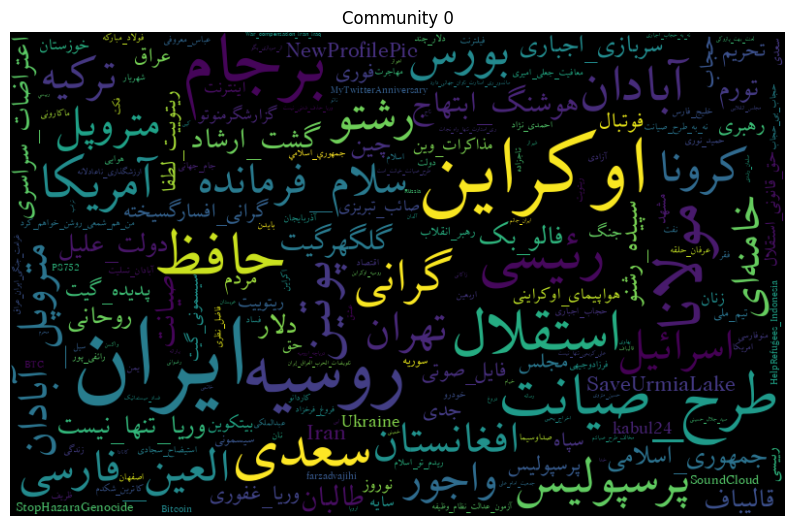

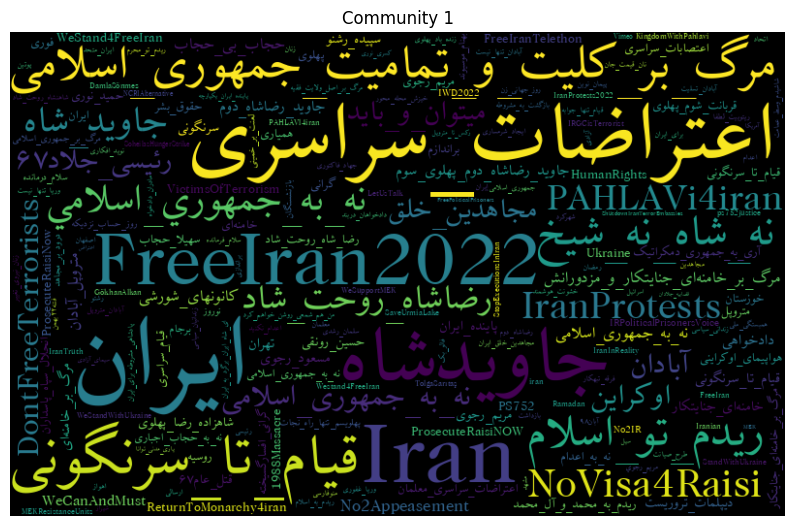

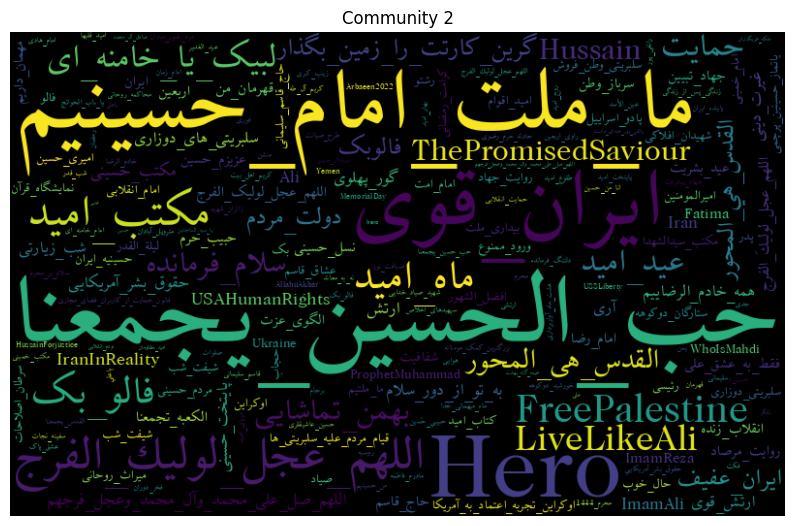

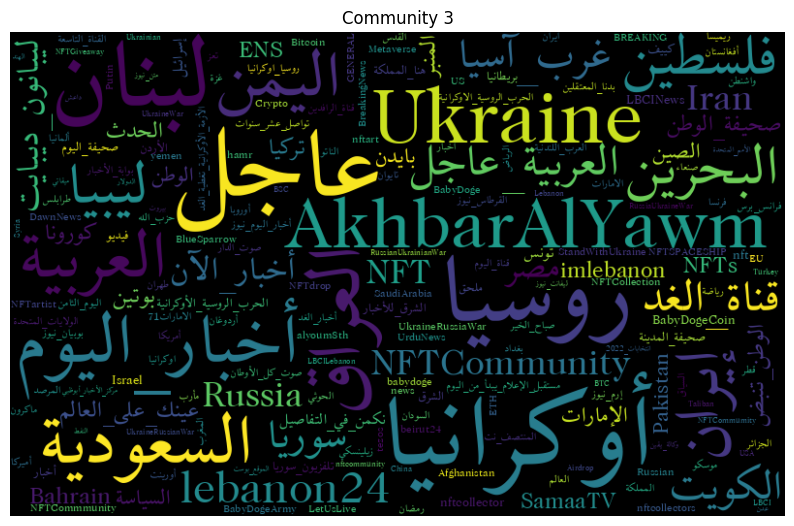

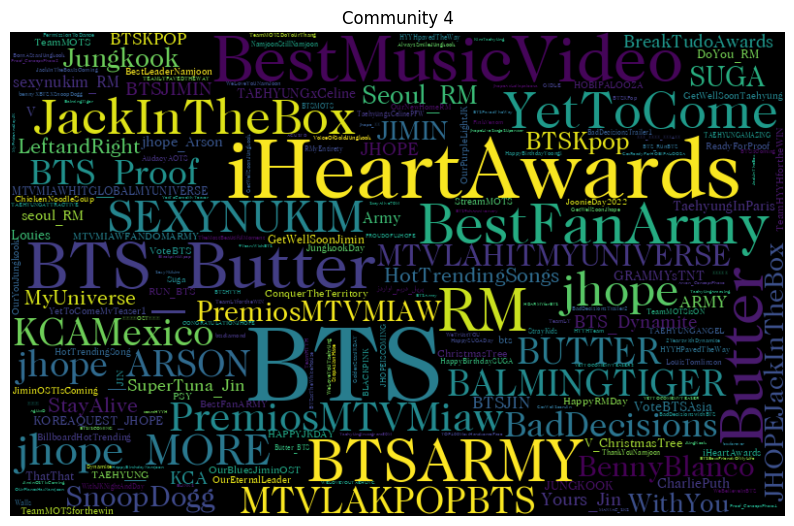

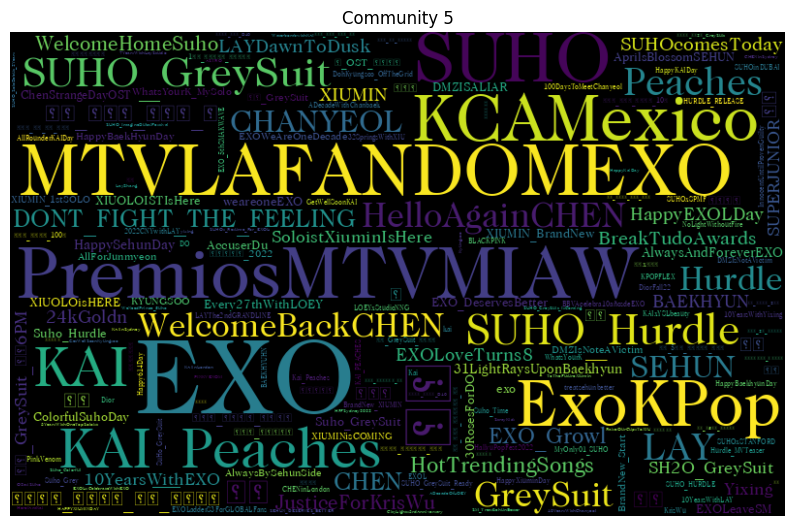

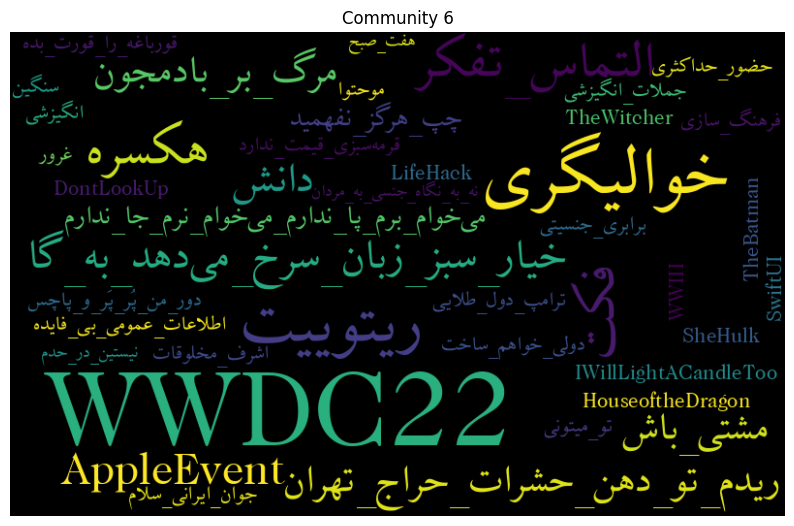

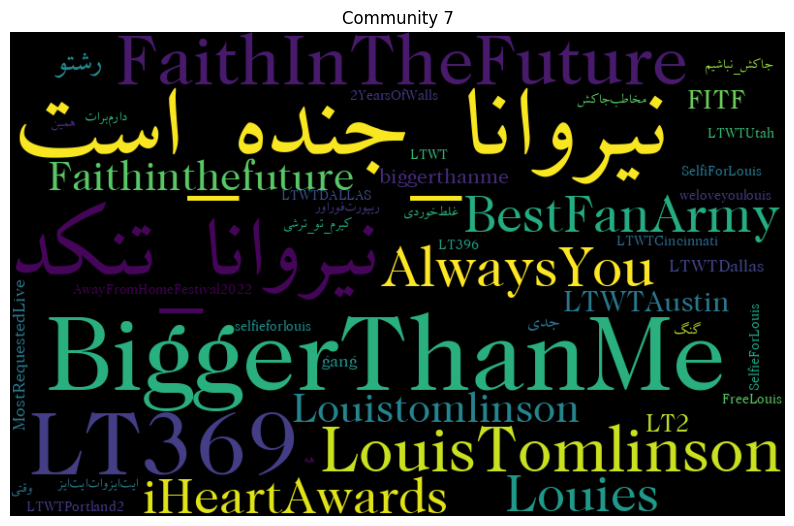

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams["axes.unicode_minus"] = False
from bidi.algorithm import get_display
import arabic_reshaper

# Number of partitions
num_partitions = df_top200_hashtags.keys()

# Generate a word cloud for each partition
for i in range(len(num_partitions)):
    # Filter the dataframe for the current partition
    df_partition = df_top200_hashtags[i]

    # Create a dictionary where the keys are the hashtags and the values are the total counts
    frequencies = df_partition.set_index("hashtag")["total_count"].to_dict()

    # text = get_display(arabic_reshaper.reshape(text))

    wordcloud = WordCloud(
        font_path="/usr/share/fonts/TTF/XB-Zar-Regular.ttf",
        width=800,
        height=500,
        random_state=21,
        max_font_size=110,
    ).generate_from_frequencies(frequencies)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Community {int(i)}")
    plt.show()

In [33]:
sample_size = 4500

# 2. Sample nodes
# Group nodes by community
groups = df.groupby('community')

# Sample from each group
sampled_nodes = groups.apply(lambda x: x.sample(n=int((x['userId'].nunique()/df['userId'].nunique())*sample_size)))

# Get the unique sampled userIds
sampled_ids = sampled_nodes['userId'].unique()

# 3. Create a subgraph
# Get the vertex indices corresponding to the sampled user Ids
vertex_indices = [g.vs.find(name=str(i)).index for i in sampled_ids if str(i) in g.vs['name']]

# Create a subgraph
subgraph = g.subgraph(vertex_indices)

# Plot the subgraph


In [34]:
import networkx as nx
from pyvis.network import Network


# Convert igraph to networkx
G_nx = ig.Graph.to_networkx(subgraph)

# Create a pyvis network
G_pyvis = Network(notebook=True)
G_pyvis.from_nx(G_nx)

# Show the network
G_pyvis.show("graph.html")

graph.html
